### Prepare the Dataset for Building a Predictive Model

As a first step we will build a Random Forest model predict ERK2 activity.  We will train the model to distinguish a set of ERK2 active compounds from a set of decoy compounds.  The active and decoy compounds are derived from the DUD-E database. In order to generate the best model, we would like to decoys with property distributions similar to those of our active compounds.  Let's say this was not the case and the inactive compounds had lower molecular weight than the active compounds.  In this case our classifer may be trained to simply separate low molecular compounds from 
high molecular weight compounds.  This classifer will have very limited utility in preactice. 

As a first step, we will examine a few calculated properties of our active and decoy molecules.  In order to build a reliable model, we need to ensure that the properties of the active molecules are similar to those of the decoy molecules. 

First lets import the libraries we will need. 

In [57]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolops
import seaborn as sns
from tqdm import tqdm
import numpy as np

Now we can read a SMILES file into a Pandas dataframe and add an RDKit molecule to the dataframe. Note that since the input file is a file cotaining columns separated by a space character, we use pd.read_csv with sep=" ".

In [2]:
active_df = pd.read_csv("../data/mk01/actives_final.ism",header=None,sep=" ")
active_rows,active_cols = active_df.shape
active_df.columns = ["SMILES","ID","ChEMBL_ID"]
active_df["label"] = ["Active"]*active_rows
PandasTools.AddMoleculeColumnToFrame(active_df,"SMILES","Mol")


Let's define a function to add caculated properties to a dataframe

In [3]:
def add_property_columns_to_df(df_in):
    df_in["mw"] = [Descriptors.MolWt(mol) for mol in df_in.Mol]
    df_in["logP"] = [Descriptors.MolLogP(mol) for mol in df_in.Mol]
    df_in["charge"] = [rdmolops.GetFormalCharge(mol) for mol in df_in.Mol]

With this function in hand, we can calculate the molecular weight, LogP and formal charge of the molecules.  Once we have these properties we can compare the distributions for the active and decoy sets. 

In [4]:
add_property_columns_to_df(active_df)

Let's look at the frist few rows of our dataframe to ensure that it makes sense.

,SMILES,ID,ChEMBL_ID,label,Mol,mw,logP,charge
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCCN5CCOCC5)OC,168691,CHEMBL318804,Active,,565.099,5.49788,0
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2c7ccccc7c6c8c5C(=O)NC8)NC)OC,86358,CHEMBL162,Active,,466.541,4.35400,0
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)Cl)Nc4cccc5c4OC(O5)(F)F,575087,CHEMBL576683,Active,,527.915,4.96202,0
3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)Cl)Nc4cccc5c4OCO5,575065,CHEMBL571484,Active,,491.935,4.36922,0
4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)Cl)Nc4cccc5c4CCC5,575047,CHEMBL568937,Active,,487.991,5.12922,0

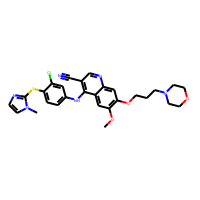
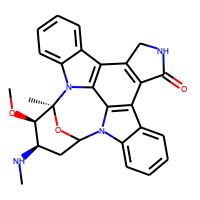
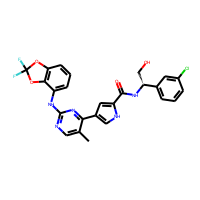
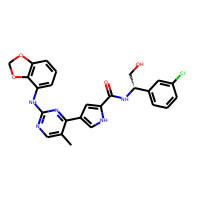
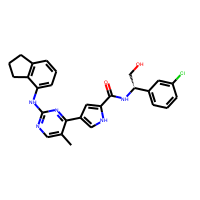

In [5]:
active_df.head()

Now let's do the same thing with the decoy molecules

In [6]:
decoy_df = pd.read_csv("../data/mk01/decoys_final.ism",header=None,sep=" ")
decoy_df.columns = ["SMILES","ID"]
decoy_rows, decoy_cols = decoy_df.shape
decoy_df["label"] = ["Decoy"]*decoy_rows
PandasTools.AddMoleculeColumnToFrame(decoy_df,"SMILES","Mol")
add_property_columns_to_df(decoy_df)

In [7]:
tmp_df = active_df.append(decoy_df,sort=False)

With properties calculated for both the active and the decoy sets, we can compare the properties of the two compound sets. To do the comparison, we will use violin plots.  A violin plot can be thought of as analogous to a boxplot.  The violin plot provides a mirrored, horizontal view of a frequency distribution.  Ideally, we would 
like to see similar distributions for the active and decoy sets.

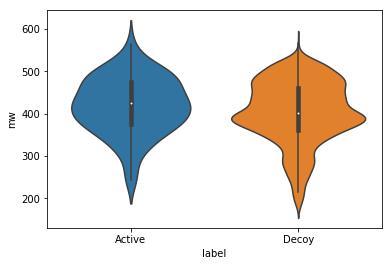

In [9]:
_ = sns.violinplot(tmp_df["label"],tmp_df["mw"])

An examination of the distributions in the figures above show that the molecular weight distributions for the two sets
are roughly equivalent.  The decoy set has more low molecular weight molecules, but the center of the distribution, show as a box in the middle of each violin plot is in a similar location in both plots. 

We can use violin plots to perform a similar comparison of the LogP distributions.  Again, we can see that the 
distributions are similar with a few more decoys at the lower end of the distribution. 

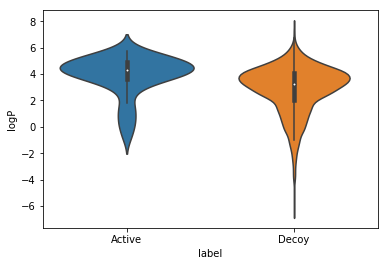

In [10]:
sns.violinplot(tmp_df["label"],tmp_df["logP"])

Finally, we will do the same comparison with the formal charges of the molecules.  

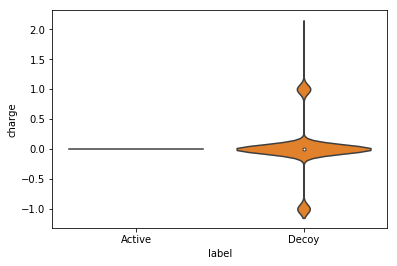

In [12]:
_ = sns.violinplot(tmp_df["label"],tmp_df["charge"])

In this case, we see a signficant difference.  All of the active molecules are neutral, while some of the decoys 
are charged. Let see what fraction of the decoy molecules are charged. We can do this by creating a new dataframe
with just the charged molecules.

In [14]:
charged = decoy_df[decoy_df["charge"] != 0]

A pandas dataframe has a property, shape, that returns the number of rows and columns in the dataframe. As such,
element[0] in the shape property will be the number of rows.  Let's divide the number of rows in our dataframe of 
charged molecules by the total number of rows in the decoy dataframe.

In [19]:
charged.shape[0]/decoy_df.shape[0]

0.16175824175824177

The fact that 16% of the decoy compounds are charged, while none of the active compounds are is a concern.  An examination of both sets indicate that charge states were assigned to the decoys, but not to the active molecules. In order to be consistent, we will use some code from the RDKit Cookbook to neutralize the molecules. First, we will import an RDKit function to neutralize charges.

In [20]:
from neutralize import NeutraliseCharges

Now we will create a new dataframe with the SMILES, ID, and label for the decoys.  

In [25]:
revised_decoy_df = decoy_df[["SMILES","ID","label"]].copy()

With this new dataframe in hand, we can replace the SMILES with the SMILES for the neutral form of the molecule. The
NeutraliseCharges function returns two values.  The first is the SMILES for the neutral form of the molecule and the second is a boolean variable indicating whether the molecule was changed.  In the code below, we only need the SMILES, so we will use the first element of the tuple returned by NeutraliseCharges.

In [26]:
revised_decoy_df["SMILES"] = [NeutraliseCharges(x)[0] for x in revised_decoy_df["SMILES"]]

Once we've replaced the SMILES, we can add a molecule column to our new dataframe and calculated properties again. 

In [27]:
PandasTools.AddMoleculeColumnToFrame(revised_decoy_df,"SMILES","Mol")
add_property_columns_to_df(revised_decoy_df)

We can now append the dataframe with the active molecules to the one with the revised, neutral decoys and calculate
another box plot. 

In [28]:
new_tmp_df = active_df.append(revised_decoy_df,sort=False)

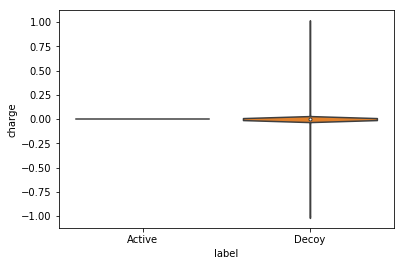

In [30]:
_ = sns.violinplot(new_tmp_df["label"],new_tmp_df["charge"])

An examination of the plot about show that there are very few charged molecules in the decoy set.  We can use the same 
technique we used above to create a dataframe with only the charged molecules.  We can then use this dataframe to determine the number of charged molecules remaining in the set. 

In [38]:
charged = revised_decoy_df[revised_decoy_df["charge"] != 0]
charged.shape[0]/revised_decoy_df.shape[0]

0.0

We have now reduced the fraction of charged compounds from 16% to 0.3%.  In order to be completely confident in our data, we will remove the remaining charged molecules from revised_decoy_df.

In [40]:
revised_decoy_df = revised_decoy_df.query("charge == 0")

Let's combine dataframes again and look at the charge distributions. 

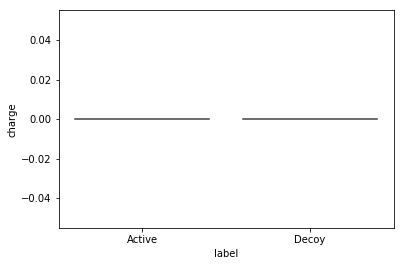

In [41]:
new_tmp_df = active_df.append(revised_decoy_df,sort=False)
_ = sns.violinplot(new_tmp_df["label"],new_tmp_df["charge"])

This looks much better, now neither the active data set nor the decoy dataset have charged molecules. 

In order to use these datasets for model building, we will write the molecules out as a csv file consisting of SMILES, Name, and an integer value indicating whether the molecules are active (labeled as 1) or inactive (labeled as 0).

In [44]:
active_df["is_active"] = [1] * active_df.shape[0]
revised_decoy_df["is_active"] = [0] * revised_decoy_df.shape[0]
combined_df = active_df.append(revised_decoy_df,sort=False)[["SMILES","ID","is_active"]]
combined_df.head()

,SMILES,ID,is_active
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCCN5CCOCC5)OC,168691,1
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2c7ccccc7c6c8c5C(=O)NC8)NC)OC,86358,1
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)Cl)Nc4cccc5c4OC(O5)(F)F,575087,1
3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)Cl)Nc4cccc5c4OCO5,575065,1
4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)Cl)Nc4cccc5c4CCC5,575047,1


In order to get a quck idea of the chemcial space covered by our active and decoy molecules, we will calculate a set of fingerprints for the molecules and perform principal component analysis (PCA).  In order to do this, we first need a couple of functions that will make it easier to calculate fingerprints and return these fingerprints as numpy arrays.

In [51]:
def fp_list_from_smiles_list(smiles_list):
    fp_list = []
    for smiles in tqdm(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        fp_list.append(fp_as_array(mol))
    return fp_list

def fp_as_array(mol):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    arr = np.zeros((1,), np.int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

Now we will calculate fingerprints for the molecules in combinded_df

In [89]:
fp_list = fp_list_from_smiles_list(combined_df.SMILES)

100%|██████████| 4617/4617 [00:01<00:00, 2340.61it/s]


The scikit-learn packages makes it very easy to perform PCA.  The three lines of code below are all that is necessary to perform PCA.

In [91]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
crds = pca.fit_transform(fp_list) 

To make life easier we will put the coordintes from the PCA into a dataframe and add the activity column from combined_df to this dataframe

In [99]:
crds_df = pd.DataFrame(crds,columns=["PC_1","PC_2"])
crds_df['active'] = list(combined_df.is_active)
crds_df.head()

,PC_1,PC_2,active
0,-0.061595,0.967282,1
1,-1.403897,0.187505,1
2,0.483235,0.845452,1
3,0.411408,0.640150,1
4,0.516745,0.242480,1


Adjust a few parameters in seaborn to make the plots look better.

In [100]:
sns.set(rc={'figure.figsize': (15, 12)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

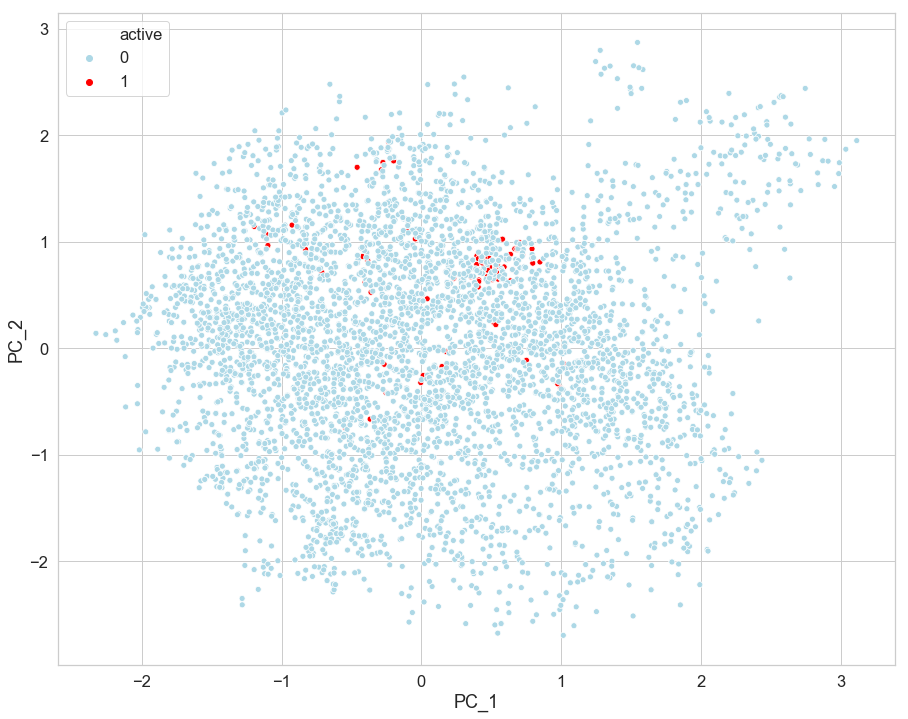

In [101]:
ax = sns.scatterplot(data=crds_df,x="PC_1",y="PC_2",hue="active",palette={0:'lightblue',1:'red'})

Note that in the plot above many of the active (red) datapoints are obscured by the blue (decoy) datapoints.  We can fix this by using two sequential plotting commands.

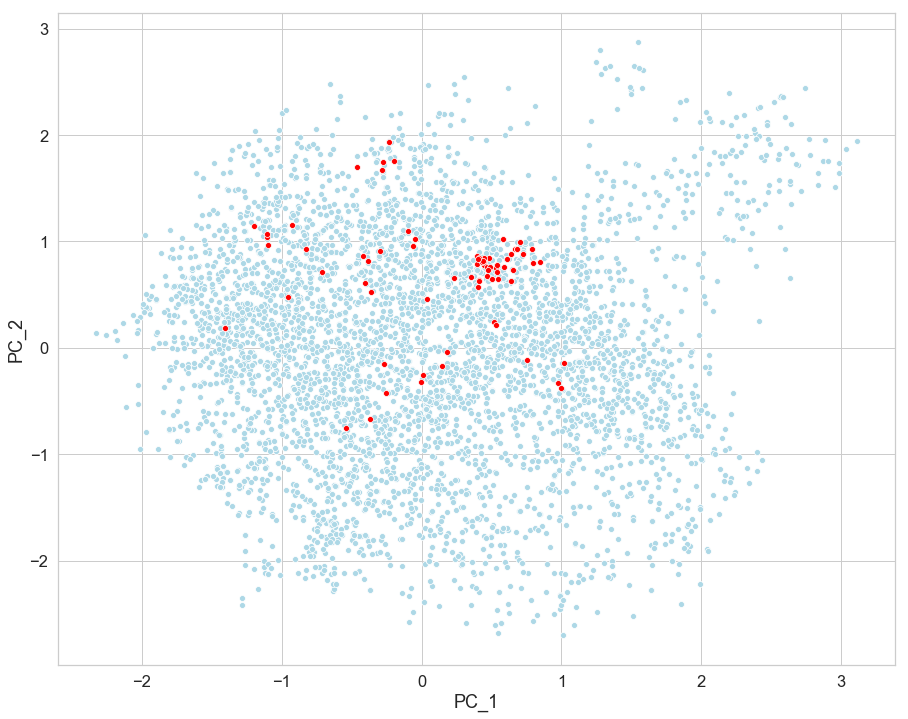

In [97]:
ax = sns.scatterplot(data=crds_df.query("active == 0"),x="PC_1",y="PC_2",color='lightblue')
ax = sns.scatterplot(data=crds_df.query("active == 1"),x="PC_1",y="PC_2",color='red')

Since we drew the lightblue points first, then drew the red points, the red points are much easier to visualize. Note also that active molecules (red) are localized within the decoy (lightblue) molecules.  This should be a relatively easy dataset for a machine learning algorithm.

Our final step in this section is to save our new combined_df as a csv file.  The index=False option causes Pandas to not include the row number in the first column. 

In [96]:
combined_df.to_csv("dude_erk1_mk01.csv")